In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
len(words)

32033

In [5]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [6]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []

for w in words:
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    context = context[1:] + [ix] # rolling window

X = torch.tensor(X)
Y = torch.tensor(Y)

In [7]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [8]:
X

tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        ...,
        [26, 26, 25],
        [26, 25, 26],
        [25, 26, 24]])

In [9]:
Y

tensor([ 5, 13, 13,  ..., 26, 24,  0])

In [10]:
# embeddings table
# take vectors and embed them in lower dimensional space
# we have 27 possible characters, we put them in 2-dimensional space

C = torch.randn((27, 2)) # embeddings table

In [11]:
C[5] # this embeds an integer into 2 dimensional vector 

tensor([-0.0762,  1.2539])

In [12]:
F.one_hot(torch.tensor(5), num_classes=27).float() @ C # this embeds an integer into 2 dimensional vector 

tensor([-0.0762,  1.2539])

In [13]:
emb = C[X]
emb.shape

torch.Size([228146, 3, 2])

In [14]:
# neural network first layer (hidden layer)
W1 = torch.randn((6, 100)) # weights
b1 = torch.randn(100) # biases

In [15]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # hidden layer with activation function
h

tensor([[-0.9997,  0.2713, -0.1613,  ...,  0.9198, -0.9994,  0.9998],
        [-0.9983, -0.0771,  0.6941,  ...,  0.7719, -0.9994,  0.9990],
        [ 0.1390, -0.3700,  1.0000,  ..., -0.7551, -0.9980,  0.8156],
        ...,
        [-0.9842,  0.9923, -0.8003,  ..., -0.9865,  0.9994,  0.9990],
        [-0.3299,  0.8777, -0.9818,  ..., -1.0000,  1.0000,  0.0885],
        [ 0.9072, -0.9948, -0.9853,  ..., -0.9869, -0.1569,  0.1590]])

In [16]:
# neural network second layer (output layer)
W2 = torch.randn((100, 27)) # weights
b2 = torch.randn(27) # biases

In [17]:
# NOW REFACTORED MLP

In [18]:
# dataset
# X - trigrams of characters
# Y - next character that comes after the trigram
X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [19]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g) # embeddings table: it basically converts any given input character into a 2 dimensional vector
# neural network first layer (hidden layer)
W1 = torch.randn((6, 100), generator=g) # weights
b1 = torch.randn(100, generator=g) # biases
# neural network second layer (output layer)
W2 = torch.randn((100, 27), generator=g) # weights
b2 = torch.randn(27, generator=g) # biases
parameters = [C, W1, b1, W2, b2]

In [20]:
sum(p.nelement() for p in parameters) # number of parameters in total

3481

In [21]:
for p in parameters:
  p.requires_grad = True

In [22]:
# lre = torch.linspace(-3, 0, 1000)
# lrs = 10**lre
# lrs

In [23]:
# training
lri = []
lossi = []

for i in range(10000):
  # minibatch construct
  ix = torch.randint(0, X.shape[0], (32, ))

  # forward pass
  emb = C[X[ix]] # (32, 3, 2), we select only 32 examples from a random minibatch
  h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # hidden layer with activation function, (32, 100)
  logits = h @ W2 +   b2
  loss = F.cross_entropy(logits, Y[ix])

  # backward pass
  for p in parameters:
    p.grad = None 
  loss.backward()

  # update
  lr = 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # # track stats
  # lri.append(lr)
  # lossi.append(loss.item())

print(loss.item())


2.6680614948272705


In [24]:
# evaluate loss for the whole dataset
emb = C[X] # (32, 3, 2), we select only 32 examples from a random minibatch
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # hidden layer with activation function, (32, 100)
logits = h @ W2 +   b2
loss = F.cross_entropy(logits, Y)
loss

tensor(2.5670, grad_fn=<NllLossBackward0>)

In [93]:
# split data in 3 parts
# training split, dev/validation split, test split
# 80%, 10%, 10%

# build the dataset

def build_dataset(words):
  block_size = 3 # context length: how many characters do we take to predict the next one?
  X, Y = [], []

  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # rolling window

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


In [95]:
# MLP
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 10), generator=g) # embeddings table: it basically converts any given input character into a 2 dimensional vector (later improvement - 10 dimensional)
# neural network first layer (hidden layer)
W1 = torch.randn((30, 200), generator=g) # weights, we scaled it up from 100 to 300 neurons
b1 = torch.randn(200, generator=g) # biases
# neural network second layer (output layer)
W2 = torch.randn((200, 27), generator=g) # weights
b2 = torch.randn(27, generator=g) # biases
parameters = [C, W1, b1, W2, b2]
for p in parameters:
  p.requires_grad = True

In [96]:
sum(p.nelement() for p in parameters)

11897

In [97]:
lri = []
lossi = []
stepi = []

In [98]:
# training

for i in range(200000):
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32, ))

  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 10), we select only 32 examples from a random minibatch
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # hidden layer with activation function, (32, 100)
  logits = h @ W2 +   b2
  loss = F.cross_entropy(logits, Ytr[ix])

  # backward pass
  for p in parameters:
    p.grad = None 
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  stepi.append(i)
  lri.append(lr)
  lossi.append(loss.log10().item())

# print(loss.item())


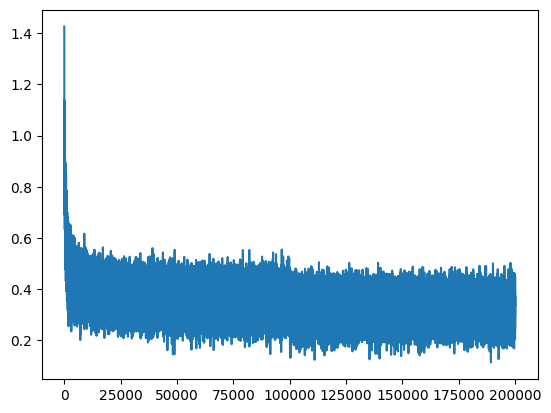

In [99]:
plt.plot(stepi, lossi)

In [100]:
# evaluate on training set
emb = C[Xtr] # (32, 3, 10), we select only 32 examples from a random minibatch
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # hidden layer with activation function, (32, 100)
logits = h @ W2 +   b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1233, grad_fn=<NllLossBackward0>)

In [101]:
# evaluate on dev set
emb = C[Xdev] # (32, 3, 10), we select only 32 examples from a random minibatch
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # hidden layer with activation function, (32, 100)
logits = h @ W2 +   b2
loss = F.cross_entropy(logits, Ydev)
# when loss on training and dev sets is roughly equal
# it means that we are underfitting: our neural network is not big and complicated enough
# we should scale it up
# next bottleneck: 2D embeddings vectors - dimensionality is too low
loss

tensor(2.1572, grad_fn=<NllLossBackward0>)

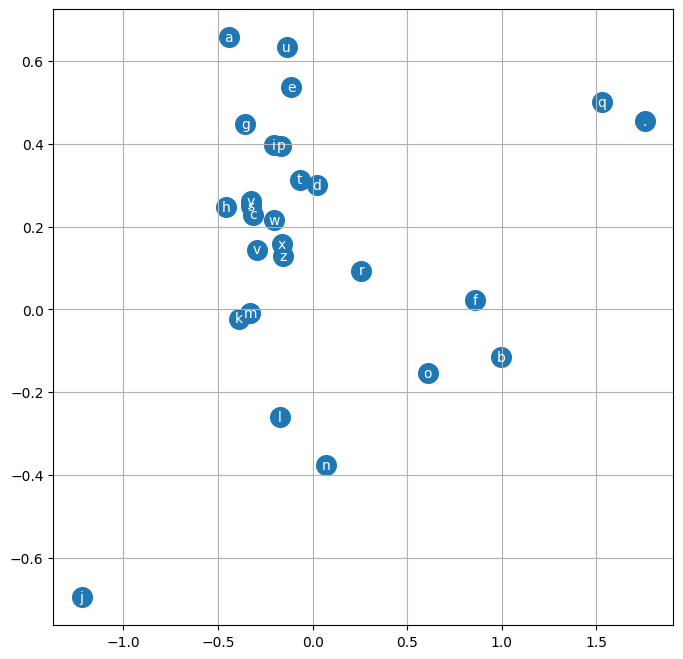

In [88]:
# visualize embeddings
plt.figure(figsize=(8,8))
plt.scatter(C[:, 0].data, C[:,1].data, s = 200)
for i in range(C.shape[0]):
  plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha='center', va="center", color='white')
plt.grid('minor')

In [106]:
# sample from the best variant of our model

g = torch.Generator().manual_seed(2147483647)
for _ in range(20):
  out = []
  context = [0] * block_size # initialize with ...

  while True:
    emb = C[torch.tensor([context])] # (1, block_size, d)
    h = torch.tanh(emb.view(1, -1) @ W1 + b1)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim=1)
    ix = torch.multinomial(probs, num_samples=1, generator=g).item()
    context = context[1:] + [ix]
    out.append(ix)
    if ix == 0:
      break
  print(''.join(itos[i] for i in out))

cerie.
coulsuriana.
kayderrinimittareel.
adn.
kator.
samiyah.
javer.
gotti.
moziella.
kinz.
teda.
kaley.
maside.
ankaviyn.
zatlan.
huciel.
vorhelsa.
dydr.
breenley.
alaira.
